ORES 'Damaging' Calibration
===

Functionally, we need to learn logistic parameters A and B, such that given a raw predicted probability y_hat the "calibrated" probability is expit(-(A * y_hat + B))

One idea: we do have access to the training data, but don't have access to an "out-of-sample" set to train a model.  So, train a cross-validated model and get A and B from the various CV folds. Then, average the A and B (after checking to ensure their variance is small) and use those to adjust the raw probabilities using the formula above. Or, average the OUTPUT of the formula above and average that. (Edit: this is the one we went with.)

https://github.com/scikit-learn/scikit-learn/blob/fd237278e/sklearn/calibration.py#L506

---

The ORES training data were extracted using the following commands:
```
cat /export/scratch2/levon003/repos/wiki-ores-feedback/data/raw/editquality/datasets/enwiki.labeled_revisions.20k_2015.json | revscoring extract editquality.feature_lists.enwiki.damaging editquality.feature_lists.enwiki.goodfaith --host https://en.wikipedia.org --extractors 32 --verbose > enwiki.labeled_revisions.w_cache.20k_2015.json

revscoring dump_cache --input enwiki.labeled_revisions.w_cache.20k_2015.json --output enwiki.labeled_revisions.20k_2015.damaging.tsv --verbose editquality.feature_lists.enwiki.damaging damaging

```


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib.colors

In [3]:
import os
from collections import Counter
import itertools
from datetime import datetime

In [4]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
import sklearn.calibration
from scipy.special import expit

In [5]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [6]:
editquality_data_dir = os.path.join(git_root_dir, "data", "raw", "editquality", "datasets")

In [7]:
df = pd.read_csv(os.path.join(editquality_data_dir, "enwiki.labeled_revisions.20k_2015.damaging.tsv"), sep='\t', header=0)
len(df)

19348

In [8]:
df.head()

,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),feature.log((wikitext.revision.parent.headings + 1)),feature.log((wikitext.revision.parent.wikilinks + 1)),feature.log((wikitext.revision.parent.external_links + 1)),...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,damaging
0,False,False,False,11.487669,9.673949,8.289037,2.890372,4.804021,5.924256,6.354370,...,2.597872,2.597872,0.0,12,12,0,11.027027,11.027027,0.0,False
1,True,True,False,9.782336,8.767173,7.884953,3.218876,2.639057,3.806662,0.693147,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
2,False,False,False,8.696009,7.963112,6.218600,1.098612,1.098612,4.304065,0.000000,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
3,True,True,False,9.205629,8.144969,7.152269,3.496508,1.945910,4.094345,2.564949,...,1.000000,1.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
4,False,False,False,7.603898,6.356108,5.323010,2.484907,0.693147,2.833213,0.693147,...,16.596429,16.596429,0.0,7,7,0,5.342857,5.342857,0.0,False


In [9]:
Counter(df.damaging).most_common()

[(False, 18599), (True, 749)]

In [10]:
# only 3.87% of the revisions in this set are damaging
np.sum(df.damaging) / len(df)

0.03871201157742402

### Use sklearn to train a classifier

Using basic cross-validation to evaluate it.

In [11]:
# shuffle the data
df = df.sample(frac=1)

In [12]:
# define the classifier based on the enwiki tuning report
# hyperparameters set from: https://github.com/wikimedia/editquality/blob/master/tuning_reports/enwiki.damaging.md
clf = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)

In [13]:
kf = sklearn.model_selection.KFold(n_splits=5)
train_accs = []
test_accs = []
roc_auc_list = []

train_label_list = []
test_label_list = []
train_proba_list = []
test_proba_list = []

for train_idx, test_idx in kf.split(df):
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    
    # store the labels for future calibration
    train_label_list.append(train.iloc[:,-1].to_numpy())
    test_label_list.append(test.iloc[:,-1].to_numpy())
    
    # train the model
    md = clf.fit(train.iloc[:,:-1], train.iloc[:,-1])
    
    # predict with the model
    y_pred_train = md.predict(train.iloc[:,:-1])
    y_pred_train_proba = md.predict_proba(train.iloc[:,:-1])[:,1]
    y_pred_test = md.predict(test.iloc[:,:-1])
    y_pred_test_proba = md.predict_proba(test.iloc[:,:-1])[:,1]
    train_proba_list.append(y_pred_train_proba)
    test_proba_list.append(y_pred_test_proba)
    
    # compute metrics
    acc_train = np.sum(y_pred_train == train.damaging) / len(y_pred_train)
    acc_test = np.sum(y_pred_test == test.damaging) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(test.damaging, y_pred_test_proba)
    
    # save and print metrics
    train_accs.append(acc_train)
    test_accs.append(acc_test)
    roc_auc_list.append(roc_auc)
    print(f"Train: {acc_train*100:.3f}%; test: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}")
print(f"CV train accuracy: {np.mean(train_accs)*100:.3f}%; CV test accuracy: {np.mean(test_accs)*100:.3f}%; test ROC AUC: {np.mean(roc_auc_list):.4f}")

Train: 97.648%; test: 96.357%; test ROC AUC: 0.9119
Train: 97.442%; test: 96.873%; test ROC AUC: 0.9437
Train: 97.571%; test: 96.770%; test ROC AUC: 0.9225
Train: 97.480%; test: 96.976%; test ROC AUC: 0.9343
Train: 97.532%; test: 96.640%; test ROC AUC: 0.9423
CV train accuracy: 97.535%; CV test accuracy: 96.723%; test ROC AUC: 0.9309


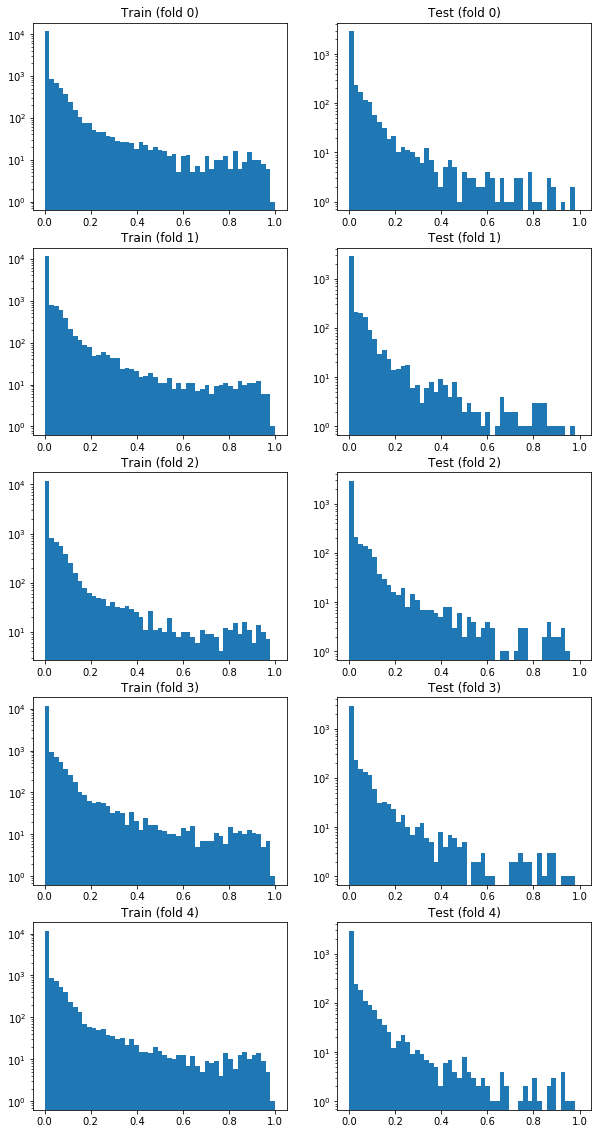

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(10, 4*5), squeeze=True)

bins = np.linspace(0, 1, num=50)

for curr_fold, row_axes in enumerate(axes):
    train_proba = train_proba_list[curr_fold]
    test_proba = test_proba_list[curr_fold]
    
    ax = row_axes[0]
    ax.hist(train_proba, bins=bins, log=True)
    ax.set_title(f"Train (fold {curr_fold})")

    ax = row_axes[1]
    ax.hist(test_proba, bins=bins, log=True)
    ax.set_title(f"Test (fold {curr_fold})")
    
plt.show()

In [15]:
train_proba_fold_calibrated_list = []
test_proba_fold_calibrated_list = []

a_list = []
b_list = []
sc_list = []

for i in range(5):
    train_proba = train_proba_list[i]
    test_proba = test_proba_list[i]
    train_label = train_label_list[i]
    test_label = test_label_list[i]
    
    sc = sklearn.calibration._SigmoidCalibration()
    sc.fit(test_proba, test_label)
    a_list.append(sc.a_)
    b_list.append(sc.b_)
    sc_list.append(sc)
    print(f"Fold {i}: A = {sc.a_:.3f}, B = {sc.b_:.3f}")
    train_proba_calibrated = sc.predict(train_proba)
    test_proba_calibrated = sc.predict(test_proba)
    train_proba_fold_calibrated_list.append(train_proba_calibrated)
    test_proba_fold_calibrated_list.append(test_proba_calibrated)
    
a_mean = np.mean(a_list)
a_std = np.std(a_list)
b_mean = np.mean(b_list)
b_std = np.std(b_list)
print(f"A (mean) = {a_mean:.3f} (std = {a_std:.3f})")
print(f"B (mean) = {b_mean:.3f} (std = {b_std:.3f})")

train_proba_calibrated_list = []
test_proba_calibrated_list = []
train_proba_meanproba_calibrated_list = []
test_proba_meanproba_calibrated_list = []
for i in range(5):
    train_proba = train_proba_list[i]
    test_proba = test_proba_list[i]

    train_proba_calibrated = expit(-(a_mean * train_proba + b_mean))
    test_proba_calibrated = expit(-(a_mean * test_proba + b_mean))
    train_proba_calibrated_list.append(train_proba_calibrated)
    test_proba_calibrated_list.append(test_proba_calibrated)
    
    m_train = []
    m_test = []
    for sc in sc_list:
        m_train.append(sc.predict(train_proba))
        m_test.append(sc.predict(test_proba))
    train_proba_meanproba_calibrated = np.mean(m_train, axis=0)
    train_proba_meanproba_calibrated_list.append(train_proba_meanproba_calibrated)
    test_proba_meanproba_calibrated = np.mean(m_test, axis=0)
    test_proba_meanproba_calibrated_list.append(test_proba_meanproba_calibrated)

Fold 0: A = -9.939, B = 3.974
Fold 1: A = -11.425, B = 4.286
Fold 2: A = -9.983, B = 4.172
Fold 3: A = -11.038, B = 4.303
Fold 4: A = -9.614, B = 4.183
A (mean) = -10.400 (std = 0.702)
B (mean) = 4.183 (std = 0.117)


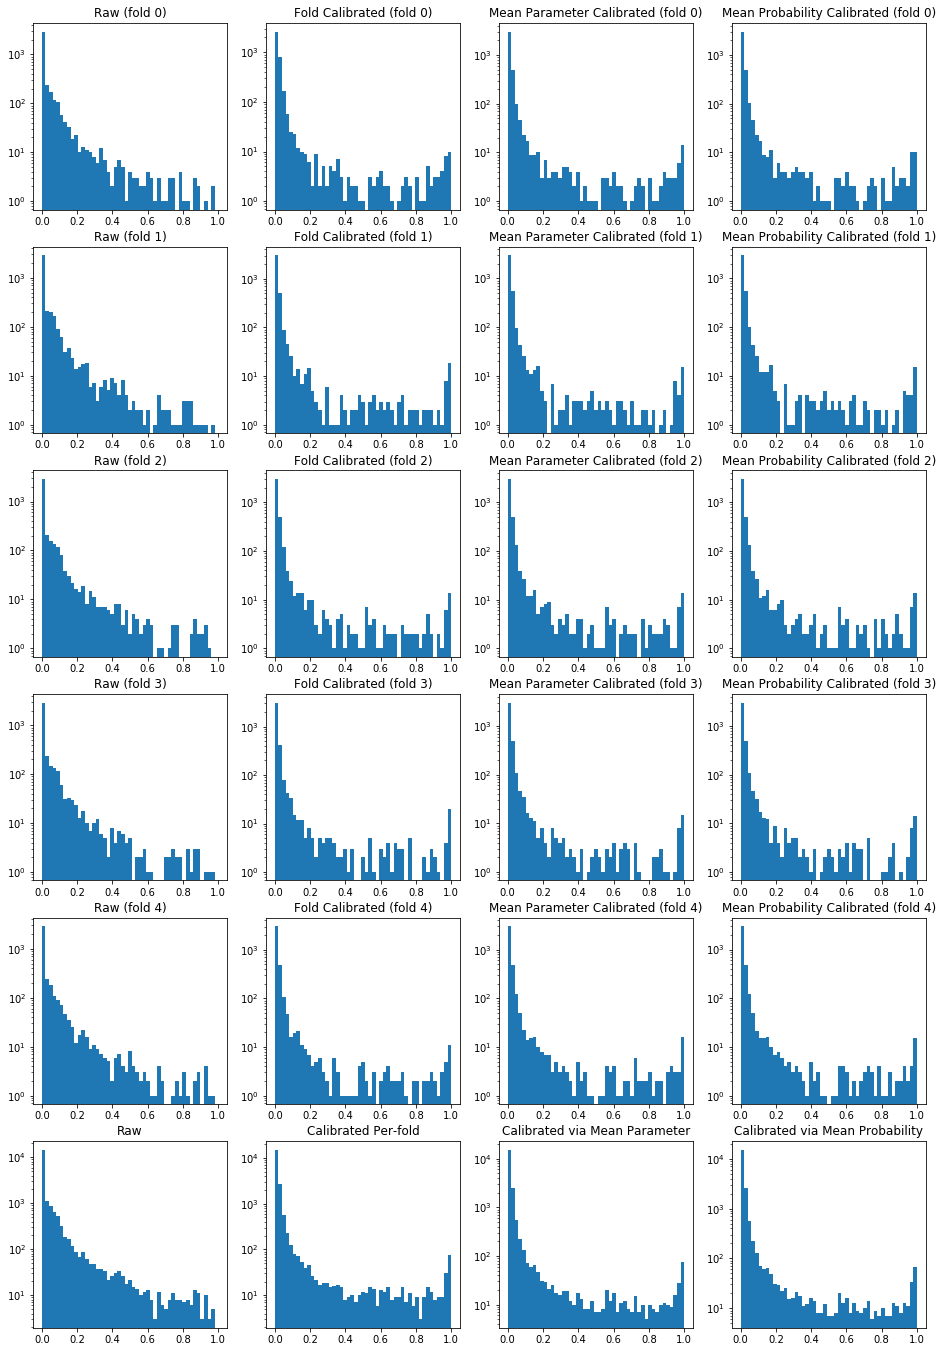

In [16]:
fig, axes = plt.subplots(6, 4, figsize=(16, 4*6), squeeze=True)

bins = np.linspace(0, 1, num=50)

for curr_fold, row_axes in enumerate(axes):
    if curr_fold == 5:
        test_proba = list(itertools.chain.from_iterable(test_proba_list))
        test_proba_fold_calibrated = list(itertools.chain.from_iterable(test_proba_fold_calibrated_list))
        test_proba_calibrated = list(itertools.chain.from_iterable(test_proba_calibrated_list))
        test_proba_meanproba_calibrated = list(itertools.chain.from_iterable(test_proba_meanproba_calibrated_list))

        ax = row_axes[0]
        ax.hist(test_proba, bins=bins, log=True)
        ax.set_title(f"Raw")

        ax = row_axes[1]
        ax.hist(test_proba_fold_calibrated, bins=bins, log=True)
        ax.set_title(f"Calibrated Per-fold")
        
        ax = row_axes[2]
        ax.hist(test_proba_calibrated, bins=bins, log=True)
        ax.set_title(f"Calibrated via Mean Parameter")
        
        ax = row_axes[3]
        ax.hist(test_proba_meanproba_calibrated, bins=bins, log=True)
        ax.set_title(f"Calibrated via Mean Probability")
    else:
        train_proba = train_proba_list[curr_fold]
        test_proba = test_proba_list[curr_fold]
        train_proba_fold_calibrated = train_proba_fold_calibrated_list[curr_fold]
        test_proba_fold_calibrated = test_proba_fold_calibrated_list[curr_fold]
        train_proba_calibrated = train_proba_calibrated_list[curr_fold]
        test_proba_calibrated = test_proba_calibrated_list[curr_fold]
        
        test_proba_meanproba_calibrated = test_proba_meanproba_calibrated_list[curr_fold]

        ax = row_axes[0]
        ax.hist(test_proba, bins=bins, log=True)
        ax.set_title(f"Raw (fold {curr_fold})")

        ax = row_axes[1]
        ax.hist(test_proba_fold_calibrated, bins=bins, log=True)
        ax.set_title(f"Fold Calibrated (fold {curr_fold})")
        
        ax = row_axes[2]
        ax.hist(test_proba_calibrated, bins=bins, log=True)
        ax.set_title(f"Mean Parameter Calibrated (fold {curr_fold})")
        
        ax = row_axes[3]
        ax.hist(test_proba_meanproba_calibrated, bins=bins, log=True)
        ax.set_title(f"Mean Probability Calibrated (fold {curr_fold})")
    
plt.show()

Fold 0: Max 0.00694; 99% 0.00231; Mean -0.00416; Std 0.00208
Fold 1: Max 0.00144; 99% 0.00144; Mean -0.00050; Std 0.00980
Fold 2: Max 0.04217; 99% 0.03577; Mean 0.00106; Std 0.00536
Fold 3: Max 0.00217; 99% 0.00217; Mean 0.00103; Std 0.00444
Fold 4: Max 0.08624; 99% 0.07123; Mean 0.00247; Std 0.01055
Max 0.08624; 99% 0.02352; Mean -0.00002; Std 0.00756


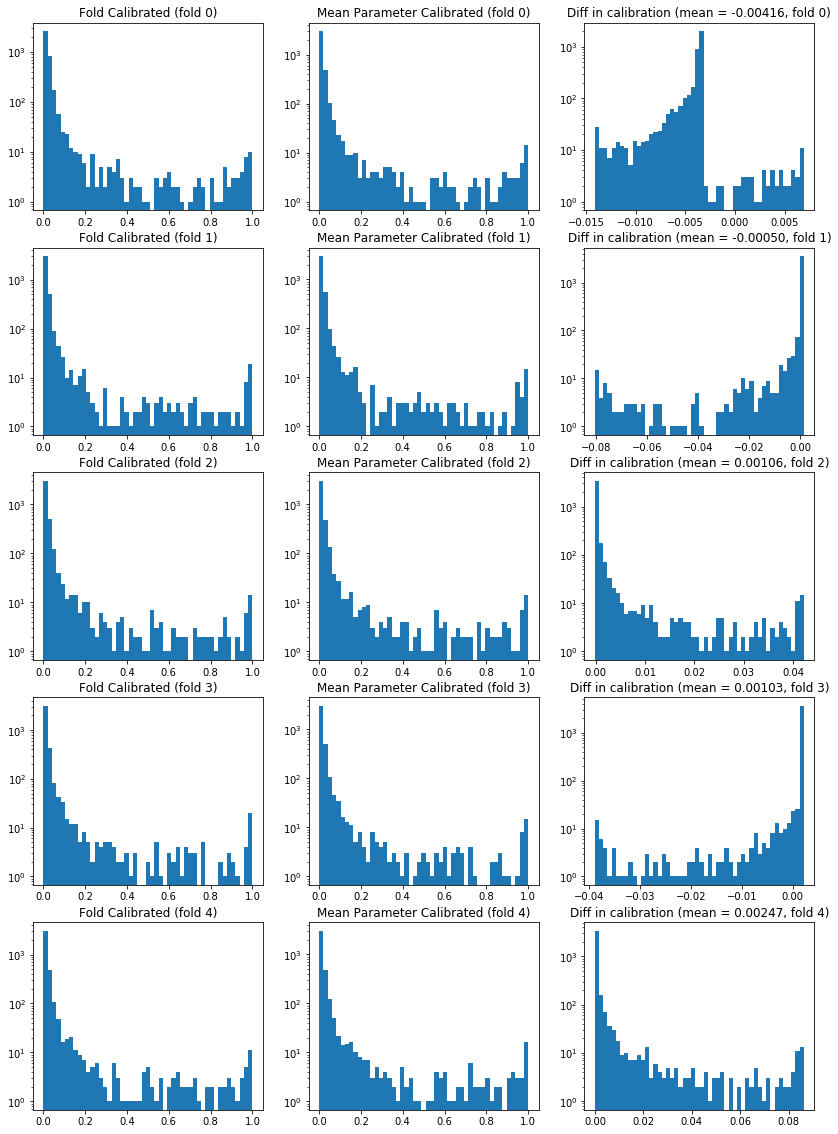

In [17]:
# comparing mean calibration to fold calibration
fig, axes = plt.subplots(5, 3, figsize=(14, 4*5), squeeze=True)

bins = np.linspace(0, 1, num=50)

all_diffs = []
for curr_fold, row_axes in enumerate(axes):
    test_proba = test_proba_list[curr_fold]
    test_proba_fold_calibrated = test_proba_fold_calibrated_list[curr_fold]
    test_proba_calibrated = test_proba_calibrated_list[curr_fold]

    ax = row_axes[0]
    ax.hist(test_proba_fold_calibrated, bins=bins, log=True)
    ax.set_title(f"Fold Calibrated (fold {curr_fold})")

    ax = row_axes[1]
    ax.hist(test_proba_calibrated, bins=bins, log=True)
    ax.set_title(f"Mean Parameter Calibrated (fold {curr_fold})")
    
    ax = row_axes[2]
    diff = test_proba_calibrated - test_proba_fold_calibrated
    all_diffs.extend(diff)
    ax.hist(diff, bins=50, log=True)
    ax.set_title(f"Diff in calibration (mean = {np.mean(diff):.5f}, fold {curr_fold})")
    print(f"Fold {curr_fold}: Max {np.max(diff):.5f}; 99% {np.quantile(diff, 0.99):.5f}; Mean {np.mean(diff):.5f}; Std {np.std(diff):.5f}")

# print a diff summary for all folds combined
print(f"Max {np.max(all_diffs):.5f}; 99% {np.quantile(all_diffs, 0.99):.5f}; Mean {np.mean(all_diffs):.5f}; Std {np.std(all_diffs):.5f}")
plt.show()

Fold 0: Max 0.00218; 99% 0.00052; Mean -0.00408; Std 0.00183
Fold 1: Max 0.00154; 99% 0.00154; Mean -0.00042; Std 0.00994
Fold 2: Max 0.04052; 99% 0.03449; Mean 0.00114; Std 0.00519
Fold 3: Max 0.00230; 99% 0.00230; Mean 0.00112; Std 0.00463
Fold 4: Max 0.08414; 99% 0.07082; Mean 0.00255; Std 0.01036
Max 0.08414; 99% 0.02297; Mean 0.00006; Std 0.00753


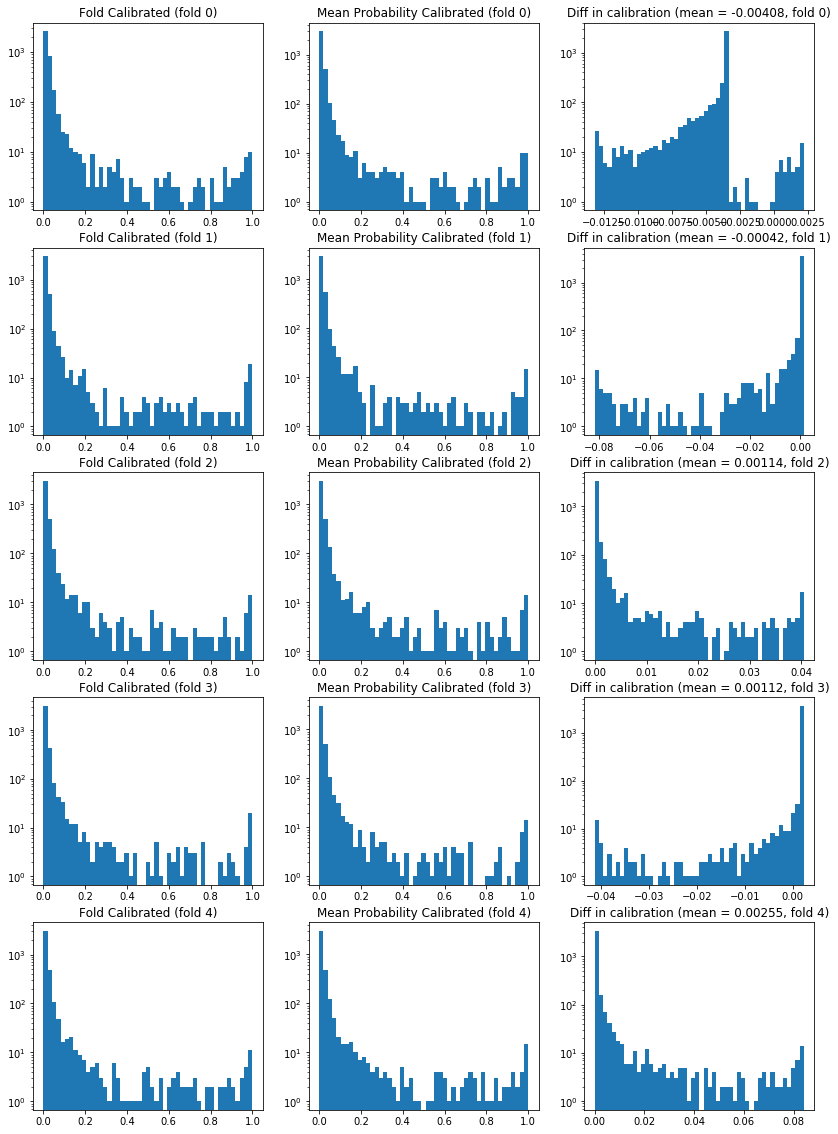

In [18]:
# comparing meanproba (sklearn) calibration to fold calibration
fig, axes = plt.subplots(5, 3, figsize=(14, 4*5), squeeze=True)

bins = np.linspace(0, 1, num=50)

all_diffs = []
for curr_fold, row_axes in enumerate(axes):
    test_proba = test_proba_list[curr_fold]
    test_proba_fold_calibrated = test_proba_fold_calibrated_list[curr_fold]
    test_proba_calibrated = test_proba_meanproba_calibrated_list[curr_fold]

    ax = row_axes[0]
    ax.hist(test_proba_fold_calibrated, bins=bins, log=True)
    ax.set_title(f"Fold Calibrated (fold {curr_fold})")

    ax = row_axes[1]
    ax.hist(test_proba_calibrated, bins=bins, log=True)
    ax.set_title(f"Mean Probability Calibrated (fold {curr_fold})")
    
    ax = row_axes[2]
    diff = test_proba_calibrated - test_proba_fold_calibrated
    all_diffs.extend(diff)
    ax.hist(diff, bins=50, log=True)
    ax.set_title(f"Diff in calibration (mean = {np.mean(diff):.5f}, fold {curr_fold})")
    print(f"Fold {curr_fold}: Max {np.max(diff):.5f}; 99% {np.quantile(diff, 0.99):.5f}; Mean {np.mean(diff):.5f}; Std {np.std(diff):.5f}")

# print a diff summary for all folds combined
print(f"Max {np.max(all_diffs):.5f}; 99% {np.quantile(all_diffs, 0.99):.5f}; Mean {np.mean(all_diffs):.5f}; Std {np.std(all_diffs):.5f}")
plt.show()

Fold 0: Max 0.00480; 99% 0.00201; Mean -0.00008; Std 0.00043
Fold 1: Max 0.00479; 99% 0.00166; Mean -0.00008; Std 0.00038
Fold 2: Max 0.00480; 99% 0.00214; Mean -0.00008; Std 0.00043
Fold 3: Max 0.00480; 99% 0.00151; Mean -0.00009; Std 0.00036
Fold 4: Max 0.00481; 99% 0.00211; Mean -0.00008; Std 0.00043
Max 0.00481; 99% 0.00189; Mean -0.00008; Std 0.00041


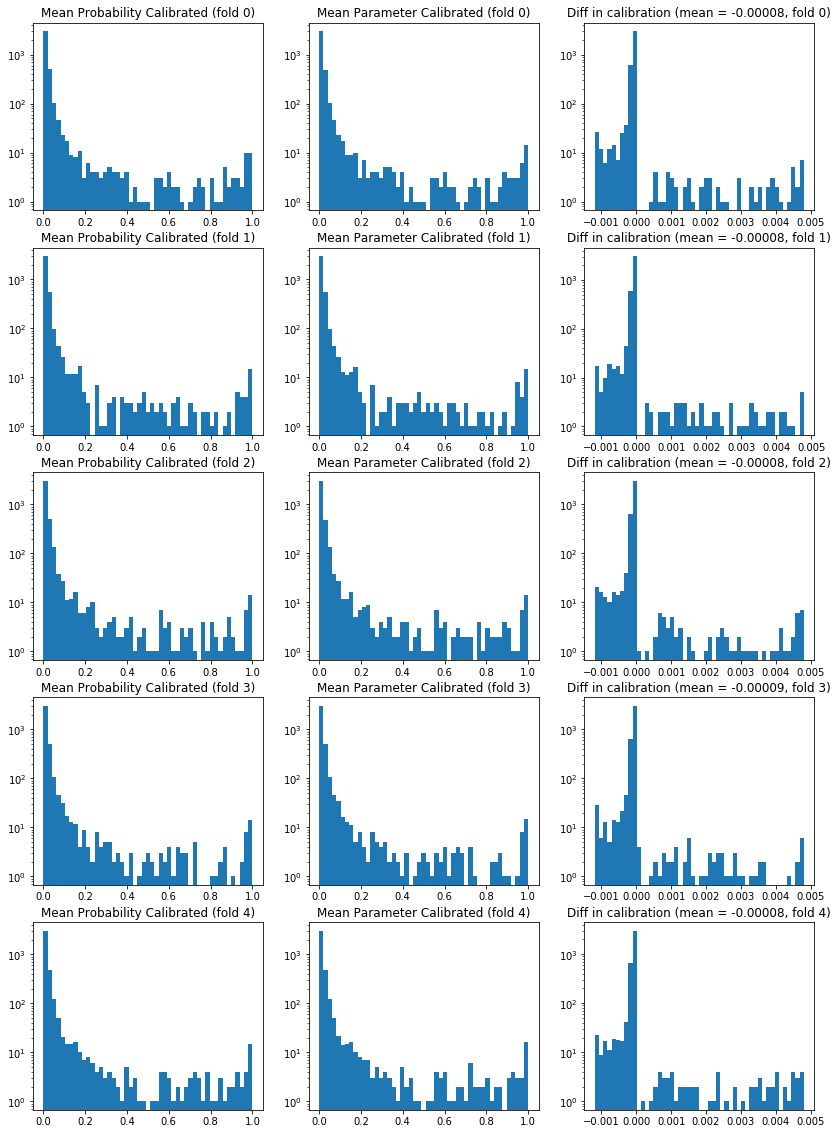

In [19]:
# comparing meanproba (sklearn) calibration to mean parameter calibration
fig, axes = plt.subplots(5, 3, figsize=(14, 4*5), squeeze=True)

bins = np.linspace(0, 1, num=50)

all_diffs = []
for curr_fold, row_axes in enumerate(axes):
    test_proba = test_proba_list[curr_fold]
    test_proba_fold_calibrated = test_proba_meanproba_calibrated_list[curr_fold]
    test_proba_calibrated = test_proba_calibrated_list[curr_fold]

    ax = row_axes[0]
    ax.hist(test_proba_fold_calibrated, bins=bins, log=True)
    ax.set_title(f"Mean Probability Calibrated (fold {curr_fold})")

    ax = row_axes[1]
    ax.hist(test_proba_calibrated, bins=bins, log=True)
    ax.set_title(f"Mean Parameter Calibrated (fold {curr_fold})")
    
    ax = row_axes[2]
    diff = test_proba_calibrated - test_proba_fold_calibrated
    all_diffs.extend(diff)
    ax.hist(diff, bins=50, log=True)
    ax.set_title(f"Diff in calibration (mean = {np.mean(diff):.5f}, fold {curr_fold})")
    print(f"Fold {curr_fold}: Max {np.max(diff):.5f}; 99% {np.quantile(diff, 0.99):.5f}; Mean {np.mean(diff):.5f}; Std {np.std(diff):.5f}")

# print a diff summary for all folds combined
print(f"Max {np.max(all_diffs):.5f}; 99% {np.quantile(all_diffs, 0.99):.5f}; Mean {np.mean(all_diffs):.5f}; Std {np.std(all_diffs):.5f}")
plt.show()

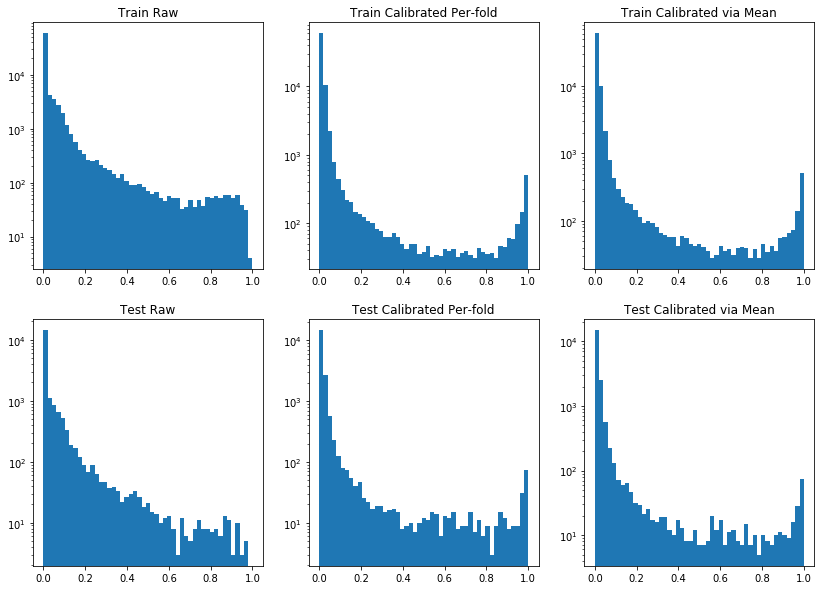

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10), squeeze=True)

bins = np.linspace(0, 1, num=50)

row_axes = axes[0]
train_proba = list(itertools.chain.from_iterable(train_proba_list))
train_proba_fold_calibrated = list(itertools.chain.from_iterable(train_proba_fold_calibrated_list))
train_proba_calibrated = list(itertools.chain.from_iterable(train_proba_calibrated_list))

ax = row_axes[0]
ax.hist(train_proba, bins=bins, log=True)
ax.set_title(f"Train Raw")

ax = row_axes[1]
ax.hist(train_proba_fold_calibrated, bins=bins, log=True)
ax.set_title(f"Train Calibrated Per-fold")

ax = row_axes[2]
ax.hist(train_proba_calibrated, bins=bins, log=True)
ax.set_title(f"Train Calibrated via Mean")

row_axes = axes[1]
test_proba = list(itertools.chain.from_iterable(test_proba_list))
test_proba_fold_calibrated = list(itertools.chain.from_iterable(test_proba_fold_calibrated_list))
test_proba_calibrated = list(itertools.chain.from_iterable(test_proba_calibrated_list))

ax = row_axes[0]
ax.hist(test_proba, bins=bins, log=True)
ax.set_title(f"Test Raw")

ax = row_axes[1]
ax.hist(test_proba_fold_calibrated, bins=bins, log=True)
ax.set_title(f"Test Calibrated Per-fold")

ax = row_axes[2]
ax.hist(test_proba_calibrated, bins=bins, log=True)
ax.set_title(f"Test Calibrated via Mean")

plt.show()

Overall, it looks like Platt scaling using the mean is fine.

Thus, we compute ORES damaging probabilities as $\text{expit}(-(A * \text{raw} + B))$, where A and B are the mean values of the Platt Coefficients

Write-up below:

---

The ORES damaging model (ORES-d) is uncalibrated by default, i.e. the raw predictions returned by the API are not intended to be direct estimates of $P(y = \text{damaging} | x)$.
To directly compare revert probability to a 'damaging' probability, we adjust the raw ORES-d scores using Platt scaling \cite{platt_probabilistic_1999}.
Platt scaling is particularly effective for boosted decision tree models, of which ORES-d is an example \cite{niculescu-mizil_predicting_2005}.
In Platt scaling, we compute $P(y = \text{damaging} | f) = 1 / (1 + \exp(A f(x) + B))$, where $f(x)$ is the output of ORES-d and $A$ and $B$ are coefficients learned via maximum likelihood estimation on a validation set.  
As we do not have access to a separate labeled validation set for calibration, we instead learn the coefficients using cross validation on the original ORES training set.
We apply Platt scaling to each of five validation folds, computing $P(y = \text{damaging} | f)$ as the mean probability.

In [21]:
a_mean, b_mean

(-10.399850427726696, 4.183482166566927)

### Calibrating ORES scores

Apply the calibration to the ORES scores

In [22]:
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')

In [23]:
# read in the ORES scores
# as sample3 is a superset of sample2 and overlaps with sample1, we also load those scores
s = datetime.now()
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
ores_dfs = []
for fname in ['sample1_ores_scores.csv', 'sample2_ores_scores.csv', 'sample3_ores_scores.csv']:
    sample_filepath = os.path.join(revision_sample_dir, fname)
    ores_dfs.append(pd.read_csv(sample_filepath, header=None, names=['rev_id', 'damaging_prob', 'damaging_pred', 'goodfaith_prob', 'goodfaith_pred']))
ores_df = pd.concat(ores_dfs, axis=0)
# remove invalid scores
ores_df = ores_df[(ores_df.damaging_prob != -1)&(ores_df.goodfaith_prob != -1)]
# remove duplicates
ores_df = ores_df.drop_duplicates(subset='rev_id')
print(f"ORES scores loaded in {datetime.now() - s}.")
len(ores_df)

ORES scores loaded in 0:01:30.257878.


34289314

In [24]:
ores_df.head()

,rev_id,damaging_prob,damaging_pred,goodfaith_prob,goodfaith_pred
0,846835190,0.014069,False,0.988118,True
1,923997118,0.597491,True,0.550084,True
2,867368228,0.304521,False,0.827948,True
3,888337768,0.010122,False,0.995091,True
4,917010365,0.013616,False,0.989612,True


In [25]:
calibrated_proba_list = []
for sc in sc_list:
    calibrated_proba_list.append(sc.predict(ores_df.damaging_prob))
damaging_prob_calibrated = np.mean(calibrated_proba_list, axis=0)
damaging_prob_calibrated.shape

(34289314,)

In [26]:
ores_df['damaging_prob_calibrated'] = damaging_prob_calibrated

In [27]:
audit_dir = os.path.join(derived_data_dir, 'audit')
calibrated_probs_filepath = os.path.join(audit_dir, 'sample3_ores_scores_calibrated.csv')
ores_df[['rev_id', 'damaging_prob', 'damaging_prob_calibrated']].to_csv(calibrated_probs_filepath, index=False)
calibrated_probs_filepath

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit/sample3_ores_scores_calibrated.csv'

In [31]:
diff = ores_df.damaging_prob_calibrated - ores_df.damaging_prob
diff.describe()

count    3.428931e+07
mean     1.096316e-02
std      7.995736e-02
min     -9.084590e-02
25%     -2.383589e-02
50%      1.201796e-03
75%      8.988159e-03
max      2.820430e-01
dtype: float64

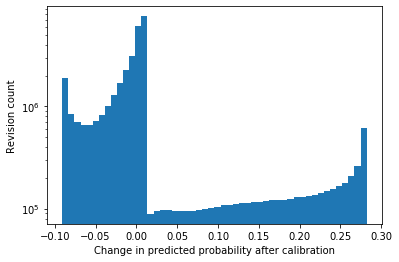

In [33]:
plt.hist(diff, bins=50, log=True)
plt.xlabel("Change in predicted probability after calibration")
plt.ylabel("Revision count")
plt.show()

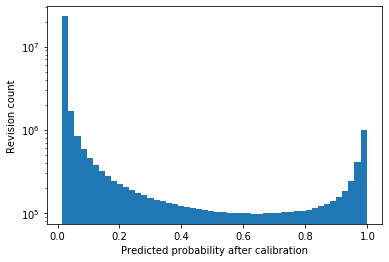

In [34]:
plt.hist(ores_df.damaging_prob_calibrated, bins=50, log=True)
plt.xlabel("Predicted probability after calibration")
plt.ylabel("Revision count")
plt.show()

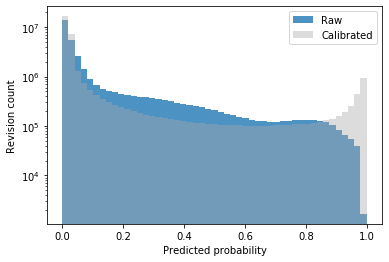

In [41]:
bins = np.linspace(0, 1, num=50)
plt.hist(ores_df.damaging_prob, bins=bins, log=True, label='Raw', alpha=0.8)
plt.hist(ores_df.damaging_prob_calibrated, bins=bins, log=True, label='Calibrated', color='darkgray', alpha=0.4)
plt.xlabel("Predicted probability")
plt.ylabel("Revision count")
plt.legend()
plt.show()